In [1]:
# author: Max Mowbray, Imperial College London 
# Contracted by ProAim for Supcon workshops

In [2]:
# imports 
import time
import numpy as np
import matplotlib.pyplot as plt

import jax
import optax
import jax.nn as jnn

import jax.numpy as jnp
import jax.random as jnr
import jax.scipy as jsp
from jax.example_libraries import optimizers
from pyswarm import pso

import diffrax
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, Dopri5


## Hybrid Modelling

Hybrid modelling combines mechanistic models, which are based on physical laws and principles, with data-driven models, such as neural networks, to leverage the strengths of both approaches. This technique is particularly useful in complex systems where purely mechanistic models may be insufficient due to unknown or highly nonlinear dynamics, and purely data-driven models may lack interpretability or require large amounts of data.

### Key Components of Hybrid Modelling

1. **Mechanistic Model**: This part of the model is derived from first principles and describes the known physical, chemical, or biological processes. It typically involves differential equations that capture the system's dynamics based on established theories.

2. **Data-Driven Model**: This component uses machine learning techniques, such as neural networks, to model the unknown or highly nonlinear parts of the system. The data-driven model is trained on experimental or historical data to learn the underlying patterns and relationships.

3. **Integration**: The hybrid model integrates the mechanistic and data-driven components. The mechanistic model provides a framework and constraints, while the data-driven model fills in the gaps and captures the complex behaviors that are difficult to model mechanistically.

### Advantages of Hybrid Modelling

- **Improved Accuracy**: By combining the strengths of mechanistic and data-driven models, hybrid models can achieve higher accuracy in predicting system behavior.
- **Interpretability**: The mechanistic component provides a clear understanding of the system based on physical laws, while the data-driven component enhances the model's flexibility and accuracy.
- **Data Efficiency**: Hybrid models can be more data-efficient than purely data-driven models, as the mechanistic component reduces the reliance on large datasets.

### Applications

Hybrid modelling is widely used in various fields, including:

- **Chemical Engineering**: For modeling complex chemical reactions and processes.
- **Biotechnology**: In systems biology and metabolic engineering to model cellular processes.
- **Pharmaceuticals**: In drug development and pharmacokinetics.

### Example Workflow

1. **Define the Mechanistic Model**: Formulate the differential equations based on known physical principles.
2. **Develop the Data-Driven Model**: Define a data-driven model
3. **Integrate the Models**: Combine the mechanistic and data-driven models to form the hybrid model.
4. **Train the model**: Use experimental or historical data to train the data-driven component.
4. **Validate the Hybrid Model**: Compare the model's predictions with experimental or real-world data to ensure accuracy.
5. **Optimize and Refine**: Adjust the model parameters and improve the integration to enhance performance.

Hybrid modelling provides a powerful approach to understanding and predicting complex systems by leveraging the strengths of both mechanistic and data-driven models.
```

## Dynamics Model

### Pure Mechanistic Model of Crystallisation of K2SO4


From the following [source](https://pubs.acs.org/doi/10.1021/acs.iecr.3c00739)

$$ \frac{d}{dt}\begin{bmatrix} \mu_0 \\ \mu_1 \\ \mu_2 \\ \mu_3 \\ C \\ T  \end{bmatrix}  =  \begin{bmatrix} r_{nuc}\\ r_1 (\mu_0 + \gamma \mu_1 ) \\ 2r_1 (\mu_1 +\gamma \mu_2) \\ 3r_1(\mu_2 +\gamma \mu_3) \\ f(\cdot)r_1(\mu_2 + \gamma \mu_3) \\ f(T, Tc)  \end{bmatrix}  $$



In [3]:
''' function to define the differential equations. Passed to diffeq solver '''
@jax.jit
def true_dynamics(t, state, params):
  ka= 0.923714966
  kb= -6754.878558
  kc= 0.92229965554
  kd= 1.341205945
  kg= 48.07514464
  k1= -4921.261419
  k2= 1.871281405
  a= 0.50523693
  b= 7.271241375
  alfa= 7.510905767
  ro= 2.658  # g/cm³
  V= 0.0005  # m³
  ro_t= 997  # kg/m³
  Cp_t= 4.117  # kJ/kg*K
  UA= 0.2154  # kJ/min*K
  Tc = 273+40

  mu0, mu1, mu2, mu3, conc, temp = state


  Ceq = -686.2686 + 3.579165 * jnp.array(temp) - 0.00292874 * jnp.array(temp) ** 2  # g/L  


  S = jnp.array(conc) * 1e3 - Ceq  # g/L
  B0 = ka * jnp.exp(kb / temp) * (S ** 2) ** (kc / 2) * ((mu3 ** 2) ** (kd / 2))  # /(cm³*min)
  Ginf = kg * jnp.exp(k1 / temp) * (S ** 2) ** (k2 / 2)  # [G] = [Ginf] = cm/min


  dmi0dt = B0
  dmi1dt = Ginf * (a * mu0 + b * mu1 * 1e-4) * 1e4
  dmi2dt = 2 * Ginf * (a * mu1 * 1e-4 + b * mu2 * 1e-8) * 1e8
  dmi3dt = 3 * Ginf * (a * mu2 * 1e-8 + b * mu3 * 1e-12) * 1e12
  dcdt = -0.5 * ro * alfa * Ginf * (a * mu2 * 1e-8 + b * mu3 * 1e-12)
  dTdt = UA * (Tc - temp) / (V * ro_t * Cp_t)

  dxdt = jnp.array([dmi0dt, dmi1dt, dmi2dt, dmi3dt, dcdt, dTdt])
  return dxdt

In [4]:
def true_dynamics_rk4(params, t0, tf, steps, dt0, x0):
  term = ODETerm(true_dynamics)
  solver = diffrax.Kvaerno5()
  stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)
  print(steps)
  saveat = SaveAt(ts=jnp.linspace(t0, tf, steps + 1))
  adjoint_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8, norm = diffrax.adjoint_rms_seminorm)
  adjoint = diffrax.BacksolveAdjoint(stepsize_controller=adjoint_controller)

  return diffeqsolve(term, solver, t0, tf, dt0, x0, args = params, stepsize_controller=stepsize_controller, adjoint = adjoint, saveat = saveat, max_steps=100000).ys#[-1, :]

#return diffeqsolve(term, solver, t0, tf, dt0, x0, args = params, saveat = saveat).ys


## Creating Dataset

Create samples based on true dynamics model.

In [5]:
def create_data(parameters, T0, TF, steps, step_size, x0):
  T = jnp.linspace(T0, TF, steps + 1)
  x_true = true_dynamics_rk4(parameters, T0, TF, steps, step_size, x0)
  jax.debug.print("True State Shape = {}".format(x_true.shape))

  random_noise = np.random.multivariate_normal(np.array([0]*x_true.shape[1]), np.diag(np.ones(x_true.shape[1])), steps + 1)
  x_obs = x_true * (1 + random_noise * 0.02)

  print("Observed State Shape = {}".format(x_obs.shape))

  return x_true, x_obs, T

In [6]:
def plot_samples(x_true, x_obs, T):
  font = {'family' : 'serif',
        'weight' : 'bold'}

  plt.rc('font', **font)
  label_tag = ['$\mu_0$', '$\mu_1$', '$\mu_2$', '$\mu_3$', 'C', 'T']
  for i in range(x_obs.shape[1]):
    plt.plot(T, (x_obs.T[i, :]- np.min(x_obs.T[i, :]))/(np.max(x_obs.T[i, :]) -np.min(x_obs.T[i, :])), '.', label = "Obs " + label_tag[i])
    plt.plot(T, (x_true.T[i, :]- np.min(x_obs.T[i, :]))/(np.max(x_obs.T[i, :])- np.min(x_obs.T[i, :])), '-', label = "True " + label_tag[i])

  plt.xlabel("Time")
  plt.ylabel("State")
  plt.title("Normalized state values over time")
  plt.legend()
  plt.show()

## Neural Network Model

The model presented above is semi-empirical given it incorporates a quadratic function of T to describe temperture dependence in the solute equilibrium concentration


$$ r_{nuc} = k_b \exp\left(\frac{-E_{Ab}}{RT}\right)ΔC^b\mu_3^\beta $$
$$\Delta C = C - C_s $$


$$ C_s(T) =-686.27 +3.5795T - 2.9287 \times 10^{-3}T^2  $$

with $C_s(T)$ identified in preliminary experiments.


Here, we will remove the quadratic expression from the model and try to learn the temperature dependence directly from reactor data as a neural network

$$ C_{eq}(T) = f_{NN}(T, \phi)$$


In [7]:

def input_scaler(inputs, scale_mean = jnp.array([155323e2*2, 2123753e2, 184700097, 2340672717.3,0.1605, 273+39.38]), scale_std = 0.5 ):
  
  """
  Scales the input values based on the provided mean and standard deviation.

  Parameters:
  inputs (jnp.ndarray): The input array to be scaled.
  scale_mean (jnp.ndarray, optional): The mean values for scaling. Default is an array with specific values.
  scale_std (float, optional): The standard deviation for scaling. Default is 0.5.

  Returns:
  jnp.ndarray: The scaled input values.
  """
  # assumes state space bounded of NN is bounded by tanh
  return jnp.divide(inputs-scale_mean, jnp.divide(scale_mean,scale_std))

def minmax_scalar(inputs, range=jnp.array([3.6641571e+02]), mini=jnp.array([2.9449063e+02]) ):    # 3.1358778e+08, 2.6019895e+09, 7.2683312e+09, 3.8483950e+10,2.8258935e-01,     1.5750447e+03, 2.2706311e+04, 1.8967081e+06, 2.4140062e+08, 1.3892503e-01,
  """
  Scales the input data using the min-max scaling method.

  Parameters:
  inputs (jnp.ndarray): The input data to be scaled.
  range (jnp.ndarray, optional): The range of the scaled data. Default is jnp.array([3.6641571e+02]).
  mini (jnp.ndarray, optional): The minimum value of the input data. Default is jnp.array([2.9449063e+02]).

  Returns:
  jnp.ndarray: The scaled input data.
  """
  return jnp.divide(inputs + mini, range)

def output_scaler(inputs, scale_min = -1, scale_max = 1):
  """
  Scales the input array to a specified range [scale_min, scale_max].

  Parameters:
  inputs (jnp.ndarray): The input array to be scaled.
  scale_min (float, optional): The minimum value of the scaled output range. Default is -1.
  scale_max (float, optional): The maximum value of the scaled output range. Default is 1.

  Returns:
  jnp.ndarray: The scaled array with values in the range [scale_min, scale_max].
  """
  return jnp.multiply(jnp.divide(inputs + jnp.array([1]), jnp.array([2])), scale_max - scale_min) + scale_min

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [8]:

''' Parameter initialization functions '''

def init_layer(m, n, rng):
  """
  Initializes the parameters of a neural network layer.

  Args:
    m (int): The number of output units.
    n (int): The number of input units.
    rng (jax.random.PRNGKey): A random number generator key.

  Returns:
    dict: A dictionary containing the initialized weights 'W' and biases 'b'.
      - 'W' (jax.numpy.ndarray): The initialized weight matrix of shape (n, m).
      - 'b' (jax.numpy.ndarray): The initialized bias vector of shape (n, 1).

  Notes:
    The weights and biases are initialized using a uniform distribution with
    a range determined by the inverse square root of the number of input units.
  """
  Wm_rng, bm_rng = jnr.split(rng, 2)
  std = 1./jnp.sqrt(n)
  W_mu = jnr.uniform(Wm_rng, (n, m), minval = -std, maxval = std)
  b_mu = jnr.uniform(bm_rng, (n, 1), minval = -std, maxval = std)

  params = {
      'W' : W_mu,
      'b' : b_mu }

  return params

def init_nn_params(init_rng, sizes):
  """
  Initialize the parameters for a Bayesian Neural Network (nn).

  Args:
    init_rng (jax.random.PRNGKey): The initial random number generator key.
    sizes (list of int): A list of integers representing the sizes of each layer in the network.

  Returns:
    dict: A dictionary where the keys are layer indices and the values are the initialized parameters for each layer.
  """
  rngs = jnr.split(init_rng, len(sizes))
  return {i:init_layer(m, n, k) for i, (k, m, n) in enumerate(zip(rngs, sizes[:-1], sizes[1:]))}

In [9]:
''' Prediction functions '''

def relu(x):
  return jnp.maximum(0, x)


def relu_6(x):
  return jnp.divide(jnp.minimum(6, jnp.maximum(0, x)),6)


def tanh(x):
  return jnp.tanh(x)


def predict(params, x):
  """
  Predict the output of a neural network given the parameters and input data.

  Args:
    params (list of dict): A list of dictionaries containing the weights ('W') and biases ('b') 
                 for each layer of the neural network.
    x (numpy.ndarray or jax.numpy.ndarray): The input data to the neural network.

  Returns:
    float: The predicted output value after passing through the neural network.
  """
  activations = x.reshape(-1,)

  activations = minmax_scalar(activations).reshape(-1,1)

  #jax.debug.print('x = {x}', x=activations)



  for i in range(len(params)-1):

    W = params[i]['W']
    b = params[i]['b']

    activations = tanh(jnp.dot(W, activations) + b)


  final_W = params[i+1]['W']
  final_b = params[i+1]['b']



  output = jnp.tanh(jnp.dot(final_W, activations) + final_b) + 1

  #jax.debug.print('x = {x}', x=output.squeeze()/2)

  return output.squeeze()/2

batched_predict = jax.vmap(predict, in_axes = (None, 0))

## Hybrid Model

In [10]:
''' function to define the differential equation using NN output for C_eq '''
@jax.jit
def hybrid_dynamics(t, state, params):
  ka= 0.923714966
  kb= -6754.878558
  kc= 0.92229965554
  kd= 1.341205945
  kg= 48.07514464
  k1= -4921.261419
  k2= 1.871281405
  a= 0.50523693
  b= 7.271241375
  alfa= 7.510905767
  ro= 2.658  # g/cm³
  V= 0.0005  # m³
  ro_t= 997  # kg/m³
  Cp_t= 4.117  # kJ/kg*K
  UA= 0.2154  # kJ/min*K
  Tc = 273+40

  mu0, mu1, mu2, mu3, conc, temp = state


  Ceq =  180 * predict(params, jnp.copy(temp)) # -686.2686 + 3.579165 * jnp.array(temp) - 0.00292874 * jnp.array(temp) ** 2  # g/L
  S = jnp.array(conc) * 1e3 - Ceq  # g/L

  B0 = ka * jnp.exp(kb / temp) * (S ** 2) ** (kc / 2) * ((mu3 ** 2) ** (kd / 2))  # /(cm³*min)
  Ginf = kg * jnp.exp(k1 / temp) * (S ** 2) ** (k2 / 2)  # [G] = [Ginf] = cm/min


  dmi0dt = B0
  dmi1dt = Ginf * (a * mu0 + b * mu1 * 1e-4) * 1e4
  dmi2dt = 2 * Ginf * (a * mu1 * 1e-4 + b * mu2 * 1e-8) * 1e8
  dmi3dt = 3 * Ginf * (a * mu2 * 1e-8 + b * mu3 * 1e-12) * 1e12
  dcdt = -0.5 * ro * alfa * Ginf * (a * mu2 * 1e-8 + b * mu3 * 1e-12)
  dTdt = UA * (Tc - temp) / (V * ro_t * Cp_t)

  dxdt = jnp.hstack([dmi0dt.reshape(1,1), dmi1dt.reshape(1,1), dmi2dt.reshape(1,1), dmi3dt.reshape(1,1), dcdt.reshape(1,1), jnp.array(dTdt).reshape(1,1)])

  return dxdt.squeeze()

## Integration Schemes for Hybrid Model

In [11]:
def hybrid_dynamics_rk4(params, t0, tf, steps, dt0, x0):
  term = ODETerm(hybrid_dynamics)
  solver = Tsit5()
  saveat = SaveAt(ts=jnp.linspace(t0, tf, steps + 1))

  return diffeqsolve(term, solver, t0, tf, dt0, x0, args = params, saveat = saveat).ys

def hybrid_dynamics_rk4_1s(params, t0, tf, steps, dt0, x0):
  """
  Solves the hybrid dynamics using the Runge-Kutta 4th order method.

  Parameters:
  params (tuple): Parameters for the hybrid dynamics function.
  t0 (float): Initial time.
  tf (float): Final time.
  steps (int): Number of steps to save the solution.
  dt0 (float): Initial time step size.
  x0 (array-like): Initial state.

  Returns:
  array-like: The final state after solving the differential equation.
  """
  term = ODETerm(hybrid_dynamics)
  solver =diffrax.Kvaerno5()
  stepsize_controller = diffrax.PIDController(rtol=1e-1, atol=1e-1)
  saveat = SaveAt(ts=jnp.linspace(t0, tf, steps + 1))
  #print(saveat)
  #adjoint_controller = diffrax.PIDController(rtol=1e-1, atol=1e-2, norm = diffrax.adjoint_rms_seminorm)
  adjoint = diffrax.RecursiveCheckpointAdjoint()
  # error handling for the diffeq solver
  try:
    return diffeqsolve(term, solver, t0, tf, dt0, x0, args = params,stepsize_controller=stepsize_controller, adjoint=adjoint, saveat = saveat, max_steps=100000).ys[-1, :]
  except:
    return x0


## Helper Functions

In [12]:
''' Root Mean Squared Error Loss '''

def rmse(x, y):
  return jnp.sqrt(jnp.mean(jnp.power(x - y, 2)))



## Negative Log Likelihood function

In [13]:
def initialise_Qmat(x_obs):
  Qmat = jnp.diag(jnp.power(jnp.std(x_obs.T, axis = 1), 2))
  Qmat = jnp.linalg.inv(Qmat)

  return Qmat

def NLL_hybrid(nn_params, rng, t0, tf, steps, step_size, x0, x_obs, Qmat):
  """
  Computes the Negative Log-Likelihood (NLL) for the hybrid dynamics of a system.

  Args:
    parameters (array-like): Parameters for the data driven function
    t0 (float): Initial time.
    tf (float): Final time.
    steps (int): Number of steps in the integration.
    step_size (float): Size of each integration step.
    x0 (array-like): Initial state of the system.
    x_obs (array-like): Observed states of the system.
    Qmat (array-like): Weight matrix for the error term.

  Returns:
    float: The computed NLL value.
  """
  dt = tf/steps
  xt = x0
  nll = jnp.array([0])

  # One step at a time
  for i in range(steps):
    xt = hybrid_dynamics_rk4_1s(nn_params, t0, dt, 1, step_size, xt)
    xerror = x_obs[i+1].reshape(1, -1) - xt.reshape(1, -1)
    nll += jnp.matmul(jnp.matmul(xerror, Qmat), xerror.T)

  #jax.debug.print("Total NLL Loss = {x}", x = nll)
  #jax.debug.print("Total KLD Loss = {x}", x = kld_lossval)
  return nll.squeeze()

def NLL_hybrid_integrator(nn_params, rng, t0, tf, steps, step_size, x0, x_obs, Qmat):
  """
  Integrates the hybrid dynamics using the scheme of choice and returns the state profile
  Parameters:
  nn_params (dict): Parameters for the Bayesian neural network.
  rng (jax.random.PRNGKey): Random number generator key.  (not used common args with other functions)
  t0 (float): Initial time.
  tf (float): Final time.
  steps (int): Number of integration steps.
  step_size (float): Step size for the integration.
  x0 (jnp.ndarray): Initial state vector.
  x_obs (jnp.ndarray): Observed state vector. (not used common args with other functions)
  Qmat (jnp.ndarray): Process noise covariance matrix. (not used common args with other functions)

  Returns:
  jnp.ndarray: History of the state vector over time.
  """
  dt = tf/steps
  xt = x0

  x_history = xt.reshape(1, -1)

  for i in range(steps):
    xt = hybrid_dynamics_rk4_1s(nn_params, t0, dt, 1, step_size, xt)
    x_history = jnp.append(x_history, xt.reshape(1, -1), axis = 0)

  return x_history


def NLL_true(parameters, t0, tf, steps, step_size, x0, x_obs, Qmat):
  """
  Computes the Negative Log-Likelihood (NLL) for the true dynamics of a system.

  Args:
    parameters (array-like): Parameters for the true dynamics function.
    t0 (float): Initial time.
    tf (float): Final time.
    steps (int): Number of steps in the integration.
    step_size (float): Size of each integration step.
    x0 (array-like): Initial state of the system.
    x_obs (array-like): Observed states of the system.
    Qmat (array-like): Weight matrix for the error term.

  Returns:
    float: The computed NLL value.
  """
  xt = true_dynamics_rk4(parameters, t0, tf, steps, step_size, x0)
  xerror = x_obs - xt
  nll = jnp.array([0])

  for i in range(xerror.shape[0]):
    jax.debug.print("State error at index {x[1]} {x[0]} ", x = [xerror[i], i])
    nll += jnp.matmul(jnp.matmul(xerror[i], Qmat), xerror[i].T)
    jax.debug.print("NLL contribution at index {x[1]} is {x[0]}", x = [jnp.matmul(jnp.matmul(xerror[i], Qmat), xerror[i].T), i])

  return nll.squeeze()

In [14]:
# wrappers (probably not needed)
def NLL_true_parameters(parameters, t0, tf, steps, step_size, x0, x_obs, Qmat ):
  return NLL_true(parameters, t0, tf, steps, step_size, x0, x_obs, Qmat)

def NLL_hybrid_parameters(nn_params, rng, t0, tf, steps, step_size, x0, x_obs, Qmat):
  return NLL_hybrid(nn_params, rng, t0, tf, steps, step_size, x0, x_obs, Qmat)

In [15]:
# gradient functions for the NLL loss with respect to nn parameters
grad_f = jax.value_and_grad(NLL_hybrid_parameters)

### Training Step

In [16]:
T0 = 0
TF = 70
paramzz = ()
steps = 20
step_size = 0.05
x0 = jnp.array([1553.23, 21237.53, 1847000.97, 234067271.73,0.1605, 273+39.38]) # Exp 4 from the paper

20
True State Shape = (21, 6)
Observed State Shape = (21, 6)


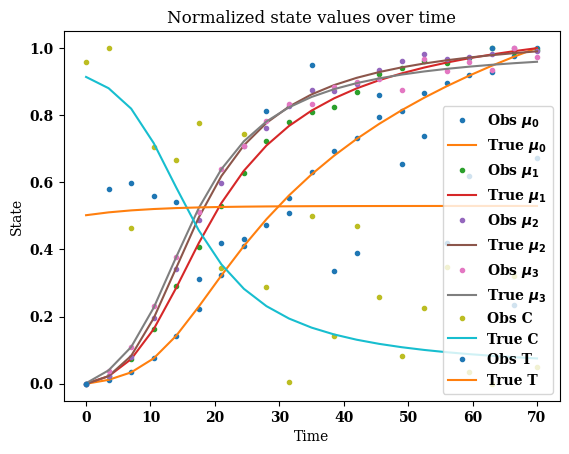

In [17]:
x_true, x_obs, T = create_data(paramzz, T0, TF, steps, step_size, x0)
plot_samples(x_true, x_obs, T)

In [18]:
# Defining scaling parameters to help with problem conditioning
Qmat = initialise_Qmat(x_obs)
Qmat = Qmat.at[0,0].set(1e-8)
Qmat = Qmat.at[1,1].set(1e-8)
Qmat = Qmat.at[2,2].set(1e-8)
Qmat = Qmat.at[3,3].set(1e-8)
Qmat = Qmat.at[4,4].set(1e-3)
Qmat = Qmat.at[5,5].set(1e-3)

In [19]:
# Reference loss for the true data generating model
cost = NLL_true_parameters(paramzz, T0, TF, steps, step_size, x0, x_obs, Qmat)
print('sum of stage costs', cost)

20
State error at index 0 [ 3.8291382e+01 -7.2163867e+02  4.0137625e+04 -6.0592480e+06
  6.5907836e-04 -1.1276001e+01] 
NLL contribution at index 0 is 367161.125
State error at index 1 [ 3.2946777e+01 -7.4328125e+01 -1.6194250e+04 -4.9443520e+06
  1.8166155e-03  1.5768127e+00] 
NLL contribution at index 1 is 244468.796875
State error at index 2 [ 5.7708008e+01  1.1634375e+02 -2.1023500e+05  4.7920640e+06
 -5.3731203e-03  1.8461914e+00] 
NLL contribution at index 2 is 230080.765625
State error at index 3 [ 7.9226562e+01  2.0836875e+03  5.6447000e+04  1.4588672e+07
 -1.5522540e-04  8.7512207e-01] 
NLL contribution at index 3 is 2128325.5
State error at index 4 [-9.6046875e+01  1.0247625e+04 -3.1427600e+05 -5.1511040e+06
  1.2493134e-03  4.3948364e-01] 
NLL contribution at index 4 is 266327.46875
State error at index 5 [-2.2041172e+03 -2.7571812e+04 -5.5428000e+05 -4.3000576e+07
  4.8474669e-03 -4.7842102e+00] 
NLL contribution at index 5 is 18493576.0
State error at index 6 [ 2.9774219e+

In [20]:

N_TARGETS = 1
N_INPUTS = 1
SIZES = [N_INPUTS, 10, 2, N_TARGETS]
GAMMA = 0.00008
rng = jnr.PRNGKey(10)
NUM_EPOCHS = 100


# Initialize nn model
nn_params = init_nn_params(rng, SIZES)

# Flatten the nn_params dictionary for use in PSO
def flatten_nn_params(nn_params):
    """
    Flatten the NN parameters dictionary into a single 1D numpy array.

    Args:
        nn_params (dict): Dictionary containing the NN parameters.

    Returns:
        numpy.ndarray: Flattened array of NN parameters.
    """
    flat_params = []
    for layer_params in nn_params.values():
        flat_params.append(layer_params['W'].ravel())
        flat_params.append(layer_params['b'].ravel())
    return np.concatenate(flat_params)

# Reconstruct the nn_params dictionary from flat_params
def unflatten_nn_params(flat_params, sizes):
    """
    Reconstruct the NN parameters dictionary from a flattened 1D numpy array.

    Args:
        flat_params (numpy.ndarray): Flattened array of nn parameters.
        sizes (list of int): List containing the sizes of each layer in the nn.

    Returns:
        dict: A dictionary containing the reconstructed nn parameters.
    """
    nn_params = {}
    index = 0
    for i, (m, n) in enumerate(zip(sizes[:-1], sizes[1:])):
        W_size = n * m
        b_size = n

        W = flat_params[index:index + W_size].reshape((n, m))
        index += W_size
        b = flat_params[index:index + b_size].reshape((n, 1))
        index += b_size

        nn_params[i] = {'W': W, 'b': b}
    return nn_params

# Define the target function wrapper for PSO

def NLL_hybrid_flattened_params(flat_params, rng, t0, tf, steps, step_size, x0, x_obs, Qmat, sizes):
    """
    Compute the negative log-likelihood (NLL) for the NN with flattened parameters.

    Args:
        flat_params (numpy.ndarray): Flattened array of NN parameters.
        rng (jax.random.PRNGKey): Random number generator key.
        t0 (float): Initial time.
        tf (float): Final time.
        steps (int): Number of time steps.
        step_size (float): Size of each time step.
        x0 (numpy.ndarray): Initial state.
        x_obs (numpy.ndarray): Observed data.
        Qmat (numpy.ndarray): Covariance matrix.
        sizes (list of int): List containing the sizes of each layer in the nn.

    Returns:
        float: The computed NLL value.
    """
    nn_params = unflatten_nn_params(flat_params, sizes)
    return NLL_hybrid_parameters(nn_params, rng, t0, tf, steps, step_size, x0, x_obs, Qmat)

# Define the Particle Swarm Optimization (PSO) function
def particle_swarm_optimize_NLL(rng, t0, tf, steps, step_size, x0, x_obs, Qmat, sizes, num_particles=50, max_iter=100):
    """
    Perform Particle Swarm Optimization (PSO) to minimize the NLL function for the nn.

    Args:
        rng (jax.random.PRNGKey): Random number generator key.
        t0 (float): Initial time.
        tf (float): Final time.
        steps (int): Number of time steps.
        step_size (float): Size of each time step.
        x0 (numpy.ndarray): Initial state.
        x_obs (numpy.ndarray): Observed data.
        Qmat (numpy.ndarray): Covariance matrix.
        sizes (list of int): List containing the sizes of each layer in the nn.
        num_particles (int, optional): Number of particles in the swarm. Default is 50.
        max_iter (int, optional): Maximum number of iterations for the PSO. Default is 100.

    Returns:
        tuple: A tuple containing the best NN parameters (dict) and the best cost (float) found by the PSO.
    """
    # Flatten initial parameters to determine dimensionality
    example_nn_params = init_nn_params(rng, sizes)
    flat_example_params = flatten_nn_params(example_nn_params)
    dim = flat_example_params.shape[0]

    # Define the bounds for each parameter; adjust as needed
    lb = -1.0 * np.ones(dim)  # lower bounds for each parameter
    ub = 1.0 * np.ones(dim)   # upper bounds for each parameter

    # Run PSO to minimize the NLL function
    best_params, best_cost = pso(
        NLL_hybrid_flattened_params,
        lb,
        ub,
        args=(rng, t0, tf, steps, step_size, x0, x_obs, Qmat, sizes),
        swarmsize=num_particles,
        maxiter=max_iter

    )

    # Reconstruct the best nn_params dictionary from the best parameters
    nn_params_best = unflatten_nn_params(best_params, sizes)
    return nn_params_best, best_cost


# **General Algorithm: PSO**
```
for each particle i = 1, ..., S do:
```
```
    Initialize the particle's position with a uniformly distributed random vector: xi ~ U(blo, bup)
    Initialize the particle's best known position to its initial position: pi ← xi
    if f(pi) < f(g) then
        update the swarm's best known position: g ← pi
    Initialize the particle's velocity: vi ~ U(-|bup-blo|, |bup-blo|)
```
```
while a termination criterion is not met do:
```
```
    for each particle i = 1, ..., S do
        for each dimension d = 1, ..., n do
            Pick random numbers: rp, rg ~ U(0,1)
            Update the particle's velocity: vi,d ← ω vi,d + φp rp (pi,d-xi,d) + φg rg (gd-xi,d)
        Update the particle's position: xi ← xi + lr vi
        if f(xi) < f(pi) then
            Update the particle's best known position: pi ← xi
            if f(pi) < f(g) then
                Update the swarm's best known position: g ← pi
```

In [ ]:
nns_params_best, best_cost = particle_swarm_optimize_NLL(rng, T0, TF, steps, step_size, x0, x_obs, Qmat, SIZES, num_particles=5, max_iter=10)


Gradient Descent (GD) is an iterative method for optimizing an objective function
with suitable smoothness properties (e.g., differentiable or sub-differentiable). It is particularly
useful for large-scale machine learning problems. In each iteration, the data is used to compute an estimate of the gradient of the objective function, and the model parameters are updated in the direction opposite to this gradient. Minibatches may also be taken instead. This gives rise to stochastic gradient descent, which helps in reducing the computational burden compared to computing the gradient over the entire dataset.

Adjoint Sensitivities, also known as the adjoint method, is a technique used to efficiently compute
gradients of a scalar-valued function with respect to a large number of parameters in continuous time models.
This method involves solving an additional set of differential equations, known as the adjoint equations,
backward in time. The adjoint method is particularly advantageous in scenarios where the number of parameters
is large, as it allows for the computation of gradients with a computational cost that is linear in
number of parameters and does not scale with the dimensionality of the vector field. This is not the case with the forward sensitivity method, which scales combinatiorially with the number of parameters and dimensionality of the vector field.

In [ ]:
lossvals = []
nn_params = nns_params_best

# ---- ADAM optimizer (works pretty well here) ---- #

linear_decay_scheduler = optax.linear_schedule(init_value=0.001, end_value=0.0000009,
                                               transition_steps=NUM_EPOCHS,
                                               transition_begin=int(NUM_EPOCHS*0.25))

optimizer = optax.adam(linear_decay_scheduler)
opt_state = optimizer.init(nn_params)

def train_step(opt_state, nn_params):
  lossval, grads = grad_f(nn_params, rng, T0, TF, steps, step_size, x0, x_obs, Qmat)
  updates, opt_state = optimizer.update(grads, opt_state, nn_params)
  nn_params = optax.apply_updates(nn_params, updates)
  return lossval, opt_state, nn_params

for epoch in range(NUM_EPOCHS):
  print(epoch)
  lossval, opt_state, nn_params = train_step(opt_state, nn_params)
  lossvals.append(lossval)
  if (epoch + 1) % 5 == 0:
     print(f"At epoch {epoch+1} loss = {lossval}")

In [ ]:
# Step LR by 0.75 every 100 steps
font = {'family': 'serif', 'weight': 'bold'}
plt.rc('font', **font)
plt.plot(range(NUM_EPOCHS), jnp.array(lossvals), linestyle='--', color='blue', marker='o', markersize=1)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('NLL Loss', fontsize=12)
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(min(lossvals),2.5e9)
plt.xlim(0,200)
plt.savefig('adjoint_trainer.svg')

plt.show()

In [ ]:
rng = jnr.PRNGKey(11)
histories = []
for n in range(1):
  new_rng, rng = jnr.split(rng)
  x_history = NLL_hybrid_integrator(nn_params, rng, T0, TF, steps, step_size, x0, x_obs, Qmat)
  histories.append(x_history)

histories = jnp.array(histories)
history_mean = jnp.mean(histories, axis=0)
history_std = jnp.std(histories, axis=0)


In [ ]:
font = {'family': 'serif', 'weight': 'bold'}
plt.rc('font', **font)
label_tag = ['$\mu_0$', '$\mu_1$', '$\mu_2$', '$\mu_3$', 'C', 'T']
for i in range(x_obs.shape[1]):
  plt.figure(figsize = (10,8))
  plt.plot(T, x_obs.T[i, :], '.', label = label_tag[i])
  plt.plot(T, history_mean.T[i, :], '-', label = 'Hybrid ' + label_tag[i])
  plt.plot(T, x_true.T[i, :], '-', label = 'Mechanistic ' + label_tag[i])
  plt.legend()
  plt.xlabel("Time")
  plt.ylabel(label_tag[i])
  plt.xlim(0,70)
  plt.savefig(label_tag[i] + '.svg')
  plt.show()
